In [57]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

FIGSIZE=(20,10)
SEED=17

In [45]:
train = pd.read_csv('../data/data_improved/train_drop_variable_renamed.csv')
test = pd.read_csv('../data/data_improved/test_drop_variable_renamed.csv')

## Check some tricks

### Check the leak in data

In [13]:
import scipy.stats as st

In [14]:
st.pearsonr(train['Id'], train['Energy_consumption'])

(-0.005617720222088148, 0.7224490688741877)

### Check the Distribution Shift

In [46]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [47]:
cols_cat = train.select_dtypes(include=['object']).columns

In [48]:
train_shift = train.drop(['Energy_consumption', "Id"], axis=1)
test_shift =  test.drop('Id', axis=1)

test_shift['is_test'] = 1
train_shift['is_test'] = 0

data = pd.concat([train_shift, test_shift], axis=0)
data = pd.get_dummies(data, columns=cols_cat)

X = data.drop('is_test', axis=1)
y = data['is_test']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                   shuffle=True,random_state=SEED,
                                                   stratify=y)

In [49]:
xgb = XGBClassifier(random_state=SEED, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
scores = cross_val_score(xgb, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)

In [50]:
scores

array([0.49057322, 0.50420252, 0.50546365, 0.51968843, 0.51728487])

In [ ]:
# we do not have the distribution shift, so the train and test sets fit each other

## Analysis

In [51]:
cols_use = [x for x in train.columns if x not in ['Id', 'Energy_consumption']]
cols_freq = list(zip(cols_use, map(lambda x: train[x].nunique(), cols_use)))
cols_freq = [(x[0], x[1], x[1]/train.shape[0]) for x in cols_freq]
cols_freq = sorted(cols_freq, key=lambda x: x[1], reverse=True)

In [52]:
# look at the relationships between most variable and target feature

In [54]:
target = 'Energy_consumption'

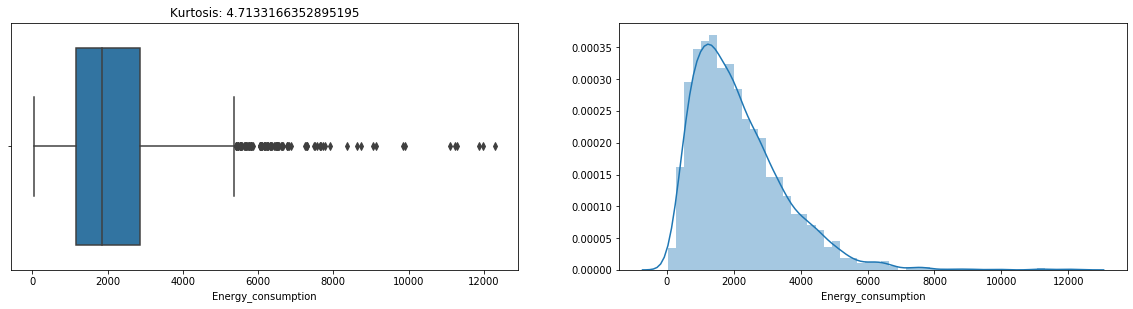

In [59]:
plt.subplots(figsize=FIGSIZE)
plt.subplot(2, 2, 1)
plt.title('Kurtosis: {}'.format(st.kurtosis(train[target])))
sns.boxplot(train[target])
plt.subplot(2, 2, 2)
sns.distplot(train[target]);

In [ ]:
# we do not have some outliers there

### Look at most variable ones

In [61]:
cols_variab = [x[0] for x in cols_freq if x[1] >= 200]

In [71]:
# check on outliers
cols_var_kurt = list(zip(cols_variab, [st.kurtosis(train[x]) for x in cols_variab]))
cols_var_kurt = sorted(cols_var_kurt, key=lambda x: x[1], reverse=True)

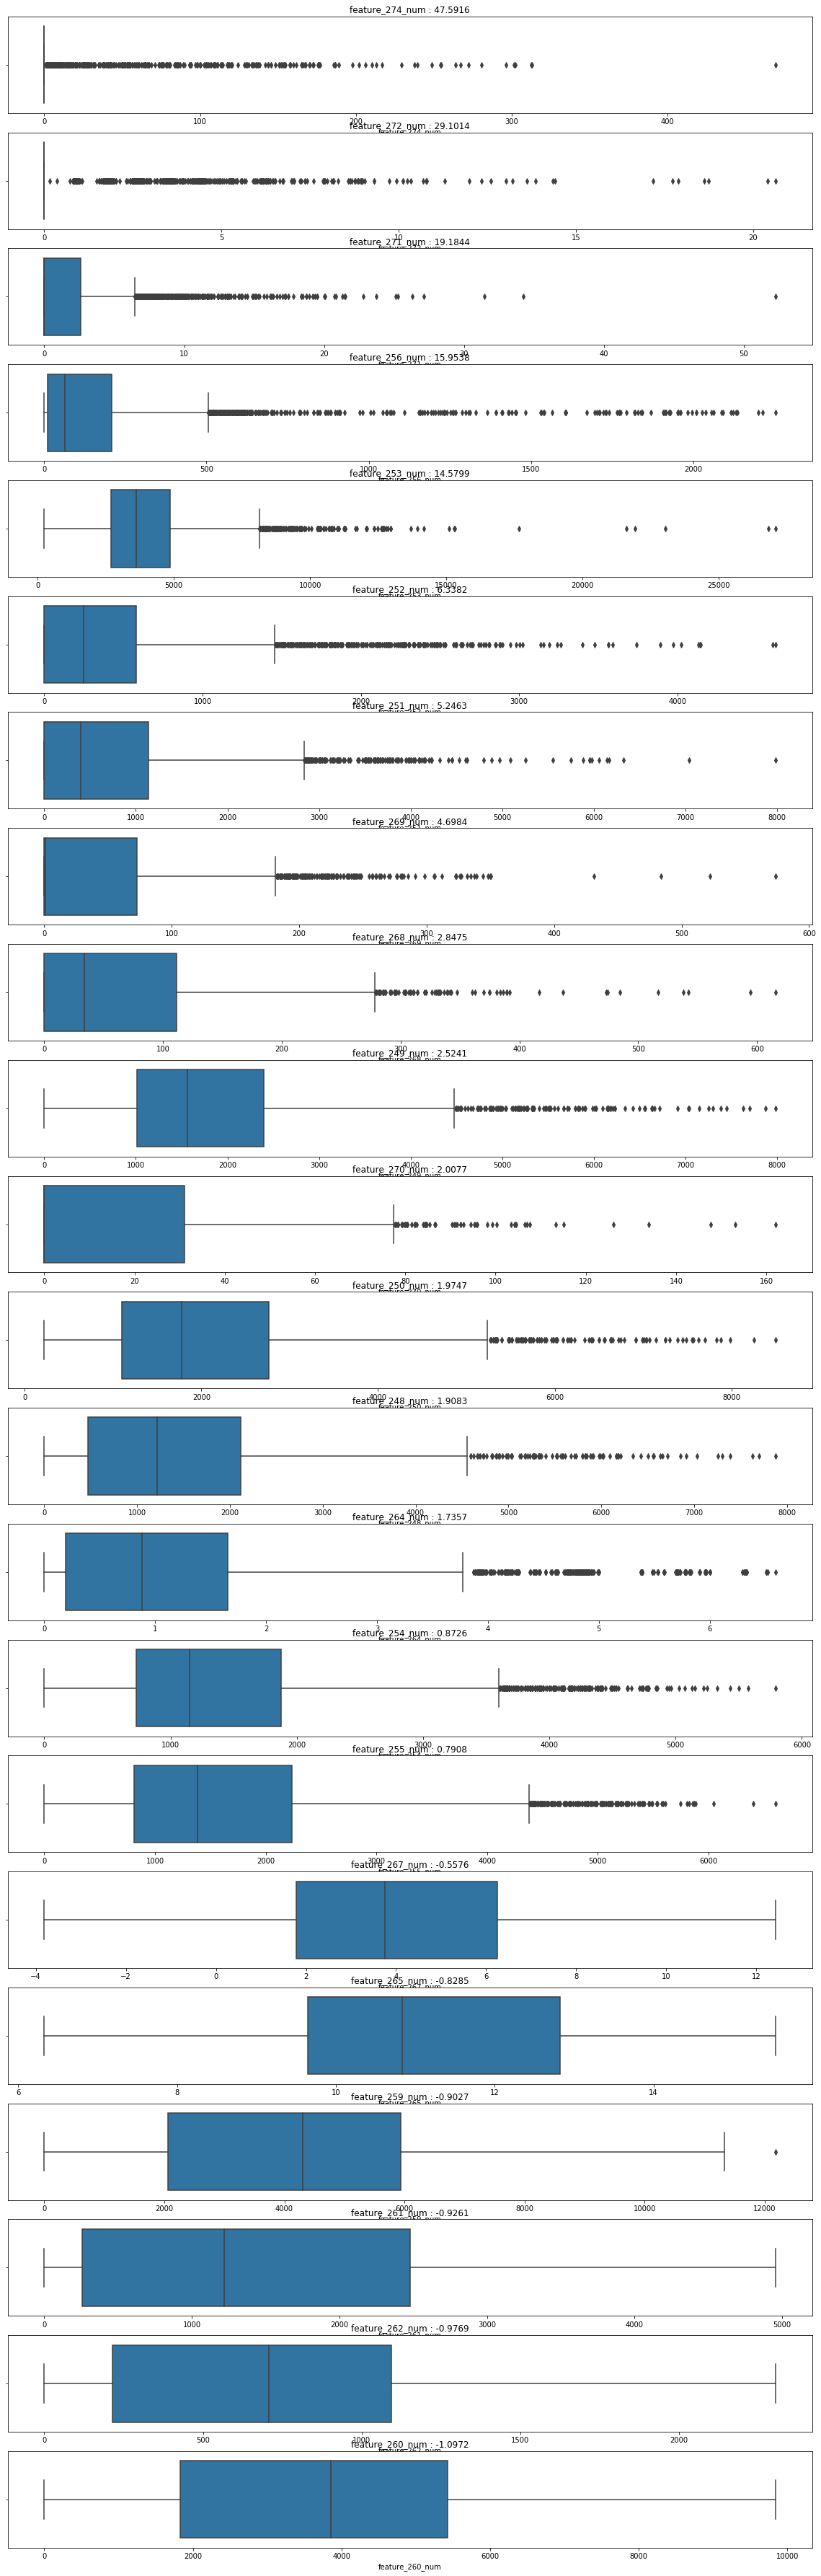

In [73]:
plt.subplots(figsize=FIGSIZE)
n = len(cols_variab)
counter=1
for col, kurt in cols_var_kurt:
    plt.subplot(n, 1, counter)
    plt.title("{} : {:.4f}".format(col, kurt))
    sns.boxplot(train[col])
    counter+=1
plt.subplots_adjust(top=5);

In [74]:
# outlier columns
cols_out = [x[0] for x in cols_var_kurt if x[1] > 13]
print(cols_out)

['feature_274_num', 'feature_272_num', 'feature_271_num', 'feature_256_num', 'feature_253_num']


In [75]:
[train[train[col] == 0].shape[0] for col in cols_out]

[3591, 3387, 2708, 769, 0]

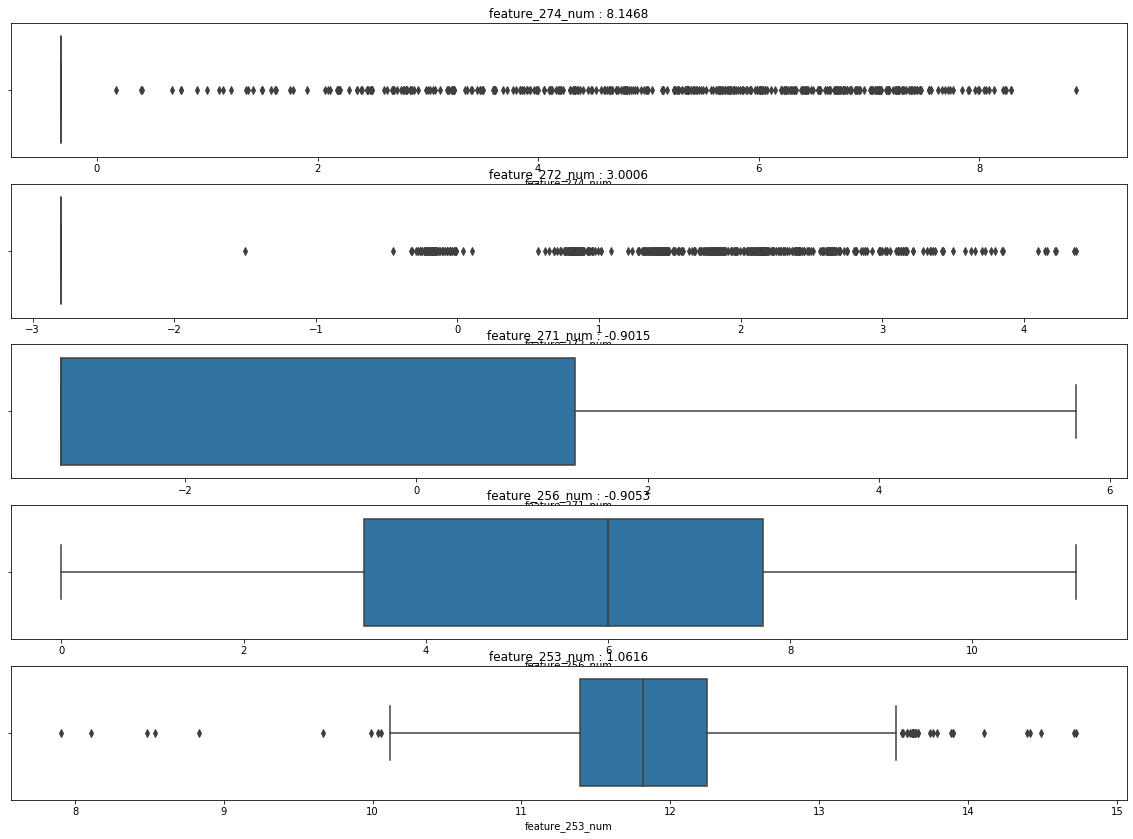

In [76]:
plt.subplots(figsize=FIGSIZE)
n = len(cols_variab)
counter=1
for col in cols_out:
    plt.subplot(n, 1, counter)
    imp = np.log2(train[train[col] > 0][col].min())
    x = train[col].copy()
    x = x.apply(lambda x: np.log2(x) if x > 0 else imp)
    
    plt.title("{} : {:.4f}".format(col, st.kurtosis(x)))
    sns.boxplot(x)
    counter+=1
plt.subplots_adjust(top=5);

In [77]:
for col in cols_out:
    imp = np.log2(train[train[col] > 0][col].min())
    train[col] = train[col].apply(lambda x: np.log2(x) if x > 0 else imp)

### Some plots

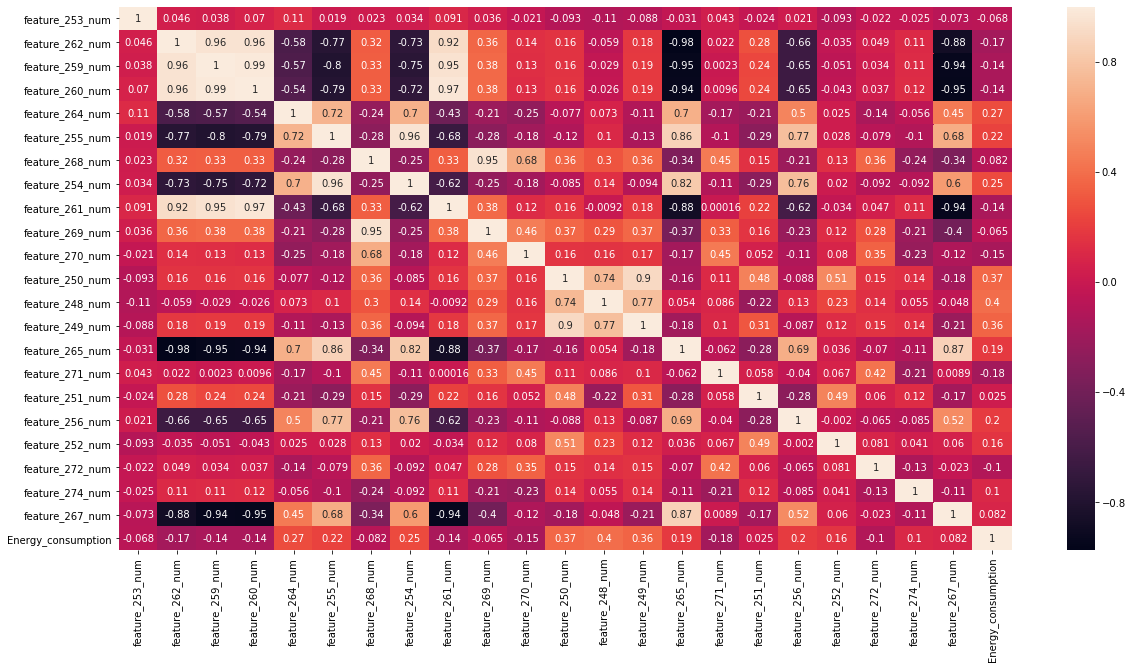

In [78]:
to_corr = train[cols_variab + [target]].corr()
plt.subplots(figsize=FIGSIZE)
sns.heatmap(to_corr, annot=True);

In [79]:
cols_out

['feature_274_num',
 'feature_272_num',
 'feature_271_num',
 'feature_256_num',
 'feature_253_num']

In [80]:
len(cols_freq)

243

In [82]:
cols_freq

[('feature_253_num', 3740, 0.935),
 ('feature_262_num', 3266, 0.8165),
 ('feature_259_num', 2985, 0.74625),
 ('feature_260_num', 2952, 0.738),
 ('feature_264_num', 2715, 0.67875),
 ('feature_255_num', 2379, 0.59475),
 ('feature_268_num', 2305, 0.57625),
 ('feature_254_num', 2242, 0.5605),
 ('feature_261_num', 2167, 0.54175),
 ('feature_269_num', 2005, 0.50125),
 ('feature_270_num', 1912, 0.478),
 ('feature_250_num', 1865, 0.46625),
 ('feature_248_num', 1853, 0.46325),
 ('feature_249_num', 1815, 0.45375),
 ('feature_265_num', 1456, 0.364),
 ('feature_271_num', 1277, 0.31925),
 ('feature_251_num', 1219, 0.30475),
 ('feature_256_num', 718, 0.1795),
 ('feature_252_num', 679, 0.16975),
 ('feature_272_num', 600, 0.15),
 ('feature_274_num', 402, 0.1005),
 ('feature_267_num', 215, 0.05375),
 ('feature_266_num', 136, 0.034),
 ('feature_200_num', 68, 0.017),
 ('feature_68_num', 47, 0.01175),
 ('feature_280_num', 44, 0.011),
 ('feature_168_num', 43, 0.01075),
 ('feature_59_num', 41, 0.01025),
 ('

In [ ]:
# some features have significant relationship with target, but we also have collinearity problems
# we can try PCA for this problem

### Look on features mostly correlated with target

In [ ]:
# take numerical features and take those with high correlations to analyse them first

In [91]:
cols_check = train.drop([target, 'Id'], axis=1).select_dtypes(exclude=['object']).columns

In [92]:
cols_corr = list(zip(cols_check, [st.pearsonr(train[col], train[target])[0] for col in cols_check]))
cols_corr = sorted(cols_corr, key=lambda x: abs(x[1]), reverse=True)

In [93]:
cols_corr

[('feature_173_cat', 0.4220990468682335),
 ('feature_21_cat', 0.41427021068111625),
 ('feature_32_cat', 0.41155887729825885),
 ('feature_17_cat', 0.39933061070550363),
 ('feature_248_num', 0.39744529295363434),
 ('feature_92_num', 0.39172432216673453),
 ('feature_86_num', 0.3853559433907159),
 ('feature_18_cat', 0.3826699699706335),
 ('feature_155_cat', 0.3776435992678592),
 ('feature_91_cat', 0.3757514268371016),
 ('feature_26_cat', 0.3745979196591135),
 ('feature_5_cat', -0.3738513317866628),
 ('feature_250_num', 0.37001624575768954),
 ('feature_94_cat', 0.36562723755471715),
 ('feature_162_cat', -0.3613995666804161),
 ('feature_167_cat', 0.3593717429684692),
 ('feature_249_num', 0.359110203826262),
 ('feature_165_cat', 0.3589851724015894),
 ('feature_283_cat', -0.35776448111506354),
 ('feature_16_cat', -0.3543194178677188),
 ('feature_41_cat', 0.35130507641796915),
 ('feature_40_cat', 0.3410643196311166),
 ('feature_42_cat', 0.34066222058972484),
 ('feature_174_cat', 0.3389006672421

In [94]:
cols_corr_interest = [x[0] for x in cols_corr if abs(x[1]) > .3]

In [96]:
len(cols_corr_interest)

46

## Baseline

### Initial data

In [172]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [173]:
train_initial = pd.read_csv('../data/train.csv')
X = train_initial.drop(['Id', target], axis=1)
y = train_initial[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, 
                                                   random_state=SEED,
                                                   shuffle=True)

In [174]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 285), (3000,), (1000, 285), (1000,))

In [175]:
y_train.std(), y_test.std()

(1416.3536376665963, 1281.4285390789423)

In [176]:
from sklearn.preprocessing import OneHotEncoder

In [177]:
catcols = X_train.select_dtypes(include='object').columns
onehot = OneHotEncoder()

train_trans = pd.DataFrame(onehot.fit_transform(X_train[catcols]).toarray())
test_trans = pd.DataFrame(onehot.transform(X_test[catcols]).toarray())

In [178]:
X_train = pd.concat([X_train.drop(catcols, axis=1).reset_index(drop=True), 
                     train_trans], axis=1)
X_test = pd.concat([X_test.drop(catcols, axis=1).reset_index(drop=True), 
                    test_trans], axis=1)

In [179]:
X_train.shape, X_test.shape

((3000, 303), (1000, 303))

In [189]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

scaler = StandardScaler()
pca = PCA(.95)
lr = Ridge(random_state=SEED)
pipe_lr = Pipeline([('scaler', scaler), ('pca', pca),
                    ('lr', lr)])

lasso = Lasso(alpha=1, random_state=SEED)
pipe_lasso = Pipeline([('scaler', scaler), ('pca', pca),
                       ('lr', lasso)])

scores_ridge = cross_val_score(pipe_lr, X_train, y_train, scoring=make_scorer(mean_squared_error), 
                         cv=kf)

scores_lasso = cross_val_score(pipe_lasso, X_train, y_train, scoring=make_scorer(mean_squared_error),
                              cv=kf)

In [190]:
scores_ridge

array([794138.35491938, 817326.72597683, 646415.09585835, 919396.25113432,
       719478.63654564])

In [191]:
scores_lasso

array([791082.45471668, 813399.52908155, 644622.65106191, 918788.86171639,
       719093.04075908])

In [192]:
scores_ridge.mean(), scores_ridge.std()

(779351.0128869012, 92228.13942590624)

In [193]:
scores_lasso.mean(), scores_lasso.std()

(777397.3074671202, 92199.25349949955)

### Data preprocessed

In [136]:
X = train.drop(['Id', target], axis=1)
y = train[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                   random_state=SEED,
                                                   shuffle=True)

In [137]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 243), (3000,), (1000, 243), (1000,))

In [138]:
y_train.std(), y_test.std()

(1416.3536376665963, 1281.4285390789423)

In [139]:
from sklearn.preprocessing import OneHotEncoder

In [140]:
catcols = X_train.select_dtypes(include='object').columns
onehot = OneHotEncoder()

train_trans = pd.DataFrame(onehot.fit_transform(X_train[catcols]).toarray())
test_trans = pd.DataFrame(onehot.transform(X_test[catcols]).toarray())

In [141]:
X_train = pd.concat([X_train.drop(catcols, axis=1).reset_index(drop=True), 
                     train_trans], axis=1)
X_test = pd.concat([X_test.drop(catcols, axis=1).reset_index(drop=True), 
                    test_trans], axis=1)

In [142]:
X_train.shape, X_test.shape

((3000, 261), (1000, 261))

In [169]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.decomposition import PCA

In [170]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

scaler = StandardScaler()
pca = PCA(.95)
lr = Ridge(random_state=SEED)
pipe_lr = Pipeline([('scaler', scaler), ('pca', pca),
                    ('lr', lr)])

lasso = Lasso(alpha=10, random_state=SEED)
pipe_lasso = Pipeline([('scaler', scaler), ('lr', lasso)])

scores_ridge = cross_val_score(pipe_lr, X_train, y_train, scoring=make_scorer(mean_squared_error), 
                         cv=kf)
scores_lasso = cross_val_score(pipe_lasso, X_train, y_train, scoring=make_scorer(mean_squared_error),
                              cv=kf)

In [171]:
scores_ridge

array([794138.35491938, 817326.72597683, 646415.09585835, 919396.25113432,
       719478.63654564])

In [150]:
scores_lasso

array([794503.70861199, 788008.70153755, 619128.65141779, 945720.67528083,
       745892.19514304])

In [152]:
scores_lasso.mean()

778650.7863982404